# Honor Statement

Name: Zhuoran Wu

E-mail: <zw118@georgetown.edu>

Platform: Windows

In accordance with the class policies and Georgetown's Honor Code,
I certify that, with the exceptions of the class resources and those
items noted below, I have neither given nor received any assistance
on this project.

In [59]:
# Import Library

%matplotlib inline

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img

# 1 Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we've used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.

After training your network, visualize some examples of input images and
their decoded reconstruction.

In [39]:
# Autoencoder

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [43]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 16)        4608      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 16)          0         
__________

In [47]:
history = autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=64,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 329s 5ms/step - loss: 0.3023 - val_loss: 0.3058
Epoch 2/2
60000/60000 [==============================] - 325s 5ms/step - loss: 0.2856 - val_loss: 0.2978


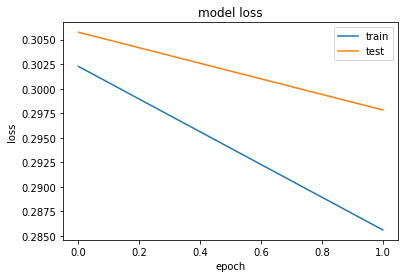

In [49]:
# Evaluate

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(history)

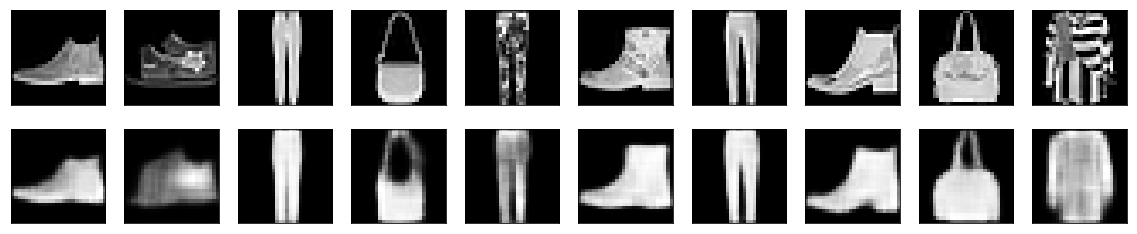

In [53]:
# Display original and reconstruction Images

decoded_imgs = autoencoder.predict(x_test)

def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[-i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[-i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

display_reconstructed(x_test, decoded_imgs, 10)

# 2 Image Classification

We'll continue to use the Fashion MNIST dataset and build a deep convolutional
network for classification.

## 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you've made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model's performance on training
set and test set.

## 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the major-
ity of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet,VGG, etc). Report on your model's performance on training set and test set.

In [26]:
# Deep CNN

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)

# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

model = Sequential()
# Must define the input shape in the first layer of the neural network
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1568)              0         
__________

In [27]:
history = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=10,
             validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 76s 1ms/step - loss: 0.5903 - acc: 0.7836 - val_loss: 0.3974 - val_acc: 0.8525
Epoch 2/10
60000/60000 [==============================] - 77s 1ms/step - loss: 0.4107 - acc: 0.8516 - val_loss: 0.3296 - val_acc: 0.8819
Epoch 3/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.3650 - acc: 0.8671 - val_loss: 0.3007 - val_acc: 0.8896
Epoch 4/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3379 - acc: 0.8764 - val_loss: 0.2911 - val_acc: 0.8924
Epoch 5/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3202 - acc: 0.8823 - val_loss: 0.2795 - val_acc: 0.8976
Epoch 6/10
60000/60000 [==============================] - 97s 2ms/step - loss: 0.3031 - acc: 0.8890 - val_loss: 0.2751 - val_acc: 0.8979
Epoch 7/10
60000/60000 [==============================] - 91s 2ms/step - loss: 0.2899 - acc: 0.8931 - val_loss: 0.2608 - val_acc

10000/10000 [==============================] - 3s 329us/step
The test score: [0.2516078155398369, 0.9094]


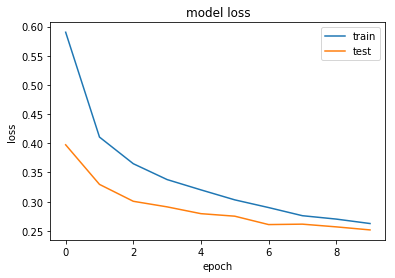

In [28]:
# Evaluate and Plot history

score = model.evaluate(x_test, y_test, verbose=1)

print("The test score: {acc}".format(acc = score))


def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(history)

In [63]:
# Transfer Learning

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Convert the images into 3 channels
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)
x_train = x_train.reshape(-1, 28,28,3)
x_test= x_test.reshape (-1,28,28,3)

# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
model = VGG16(weights="imagenet", include_top=True)
preds = model.predict(x_test)

# TODO

# 3 Text Classification

While images contain local spatial correlations and structure, many other datasets
contain temporal correlations. Examples include time series and discrete se-
quences such as text. In this problem, we will tackle the task of text classifica-
tion in the context of cybersecurity.

**Background.** When malware infects a host computer, it often needs to
reach out to an outside server for further instructions or to download additional
payloads. This outside server is called a Command-and-Control server (C2).
The malware needs to send a specific communication to the C2 server, thus the
C2 server needs to have a registered IP address or associated web domain so
that it can be reached. Therefore, being able to identify web domains that are
likely related to malware C2 can be a valuable cyber defense.

**Dataset.** Fortunately, security researchers have already identified and logged
a large number of malicious URLs. Additionally, we can catalog common "be-
nign" URLs just from typical web behavior (these would include things like
facebook.com and amazon.com). Hence, we have a labeled dataset for text
classification which can be downloaded here:

* https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt

* https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt


## 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classification task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

## 3.2 CNN

Build and train a 1D CNN for this text classification task. You might gain some
insight and inspiration from these text classification approaches:

* http://www.aclweb.org/anthology/D14-1181

* https://arxiv.org/abs/1702.08568

## 3.3

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don't forget to create a train-test split.

In [4]:
# Text Classification

def load_url_file(self, file_path, skip_lines=0):
        with open(file_path) as file:
            lines = file.readlines()
        raw_url_strings = [line[:-2] for line in lines[skip_lines:]]
        return raw_url_strings

# TODO